In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

2025-04-19 13:04:21.745944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745067861.988382      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745067862.056460      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return np.array(X), np.array(Y)

In [3]:
image_size = 224
labels = ['covid', 'pneumonia']
base_path = '/kaggle/input/covid-pneumonia-lus-images/covid_pneumonia'

# Load data
X, Y = load_data(image_size, labels, base_path)

In [4]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

# Assume X (features) and Y (labels) are defined
X_majority = X[Y == 0]  # Majority class
X_minority = X[Y == 1]  # Minority class

# Get the number of majority class samples
n_majority = len(X_majority)
# Adjust n_majority to be divisible by 10 (largest multiple of 10 <= n_majority)
n_majority_adjusted = (n_majority // 100) * 100

# Target minority class size (10% of majority class)
n_minority_target = int(n_majority_adjusted * 0.1)
# Adjust n_minority_target to be divisible by 10 (largest multiple of 10 <= n_minority_target)
n_minority_adjusted = (n_minority_target // 10) * 10

# Downsample the minority class to n_minority_adjusted samples
if n_minority_adjusted > 0:
    X_minority_downsampled, _, y_minority_downsampled, _ = train_test_split(
        X_minority, [1] * len(X_minority), train_size=n_minority_adjusted, random_state=42
    )
else:
    # Handle case where n_minority_adjusted is 0 (e.g., if n_majority is too small)
    X_minority_downsampled = np.array([])
    y_minority_downsampled = np.array([])

# Downsample the majority class to n_majority_adjusted samples
if n_majority_adjusted > 0:
    X_majority_downsampled, _, y_majority_downsampled, _ = train_test_split(
        X_majority, [0] * len(X_majority), train_size=n_majority_adjusted, random_state=42
    )
else:
    X_majority_downsampled = np.array([])
    y_majority_downsampled = np.array([])

# Combine the majority and minority classes
X_imbalanced = np.vstack((X_majority_downsampled, X_minority_downsampled)) if (len(X_majority_downsampled) > 0 and len(X_minority_downsampled) > 0) else X_majority_downsampled or X_minority_downsampled
Y_imbalanced = np.hstack((y_majority_downsampled, y_minority_downsampled)) if (len(y_majority_downsampled) > 0 and len(y_minority_downsampled) > 0) else y_majority_downsampled or y_minority_downsampled

# Print class distributions
print(f"Original Class Distribution: {Counter(Y)}")
print(f"Imbalanced Class Distribution: {Counter(Y_imbalanced)}")

Original Class Distribution: Counter({0: 524, 1: 463})
Imbalanced Class Distribution: Counter({0: 500, 1: 50})


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_imbalanced, Y_imbalanced, test_size=0.2, random_state=42)

In [6]:
# Data Augmentation & Normalisation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # ImageNet normalization
)
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',    # What to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,            # Number of epochs to wait before stopping after no improvement
    restore_best_weights=True  # Revert to best weights (optional but useful)
)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

In [10]:
def build_and_train_model_kfold(base_model, X, Y, X_test, Y_test, labels, model_name, k_folds=5):
    # Use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    # Compute class weights based on the training labels (Y)
    class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_losses = []
    conf_matrices = []
    training_times = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, Y)):
        print(f"\nTraining Fold {fold + 1}/{k_folds}...\n")

        # Splitting the dataset for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        # Define and build model within strategy scope
        with strategy.scope():
            model = Sequential([
                base_model,
                Flatten(),
                Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                Dropout(0.4),
                Dense(1, activation='sigmoid')
            ])
            optimizer = Adam(learning_rate=0.0001)
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Train the model on GPUs
        start_time = time.time()
        with strategy.scope():
            history = model.fit(
                train_datagen.flow(X_train, Y_train, batch_size=32 * strategy.num_replicas_in_sync),
                epochs=5,
                validation_data=val_datagen.flow(X_val, Y_val),
                class_weight=class_weight_dict,
                verbose=1
            )
        training_time = time.time() - start_time
        training_times.append(training_time)

        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)

        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")
        print(f"Fold {fold + 1} Validation Loss: {val_loss:.4f}")

    # Train final model on full training set
    print("\nTraining Final Model on Full Dataset...\n")
    with strategy.scope():
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    with strategy.scope():
        history = model.fit(train_datagen.flow(X, Y, batch_size=16 * strategy.num_replicas_in_sync),
                            epochs=10,
                            validation_data=val_datagen.flow(X_val, Y_val),
                            callbacks=[early_stop])
    training_time = time.time() - start_time

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f'Final Test Loss: {test_loss:.4f}')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = (Y_pred > 0.3).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'\nClassification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Summary of K-Fold Results
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    avg_time = np.mean(training_times)

    print(f"\nAverage Validation Accuracy across {k_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Validation Loss across {k_folds} folds: {avg_loss:.4f}")
    print(f"Average Training Time per fold: {avg_time:.2f} seconds")

    return history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes

I0000 00:00:1745067958.405356      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745067958.405992      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of devices: 2
Class weights: {0: 0.5405405405405406, 1: 6.666666666666667}

Training Fold 1/5...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1745067984.991567      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745067984.991578      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5904 - loss: 16.7232 - val_accuracy: 0.5909 - val_loss: 14.3623
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.8535 - loss: 11.6997 - val_accuracy: 0.7955 - val_loss: 10.3248
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.8397 - loss: 10.9905 - val_accuracy: 0.6591 - val_loss: 10.9411
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.8982 - loss: 8.5384 - val_accuracy: 1.0000 - val_loss: 7.3860
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.9215 - loss: 8.5962 - val_accuracy: 0.8182 - val_loss: 8.1993
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9308 - loss: 8.5709
Fold 1 Validation Accuracy: 0.9318
Fold 1 Validation Loss: 8.4844

Training Fold 2/5...

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6861 - loss: 12.5378 - val_accuracy: 0.8636 - val_loss: 11.1154
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.8703 - loss: 12.0379 - val_accu

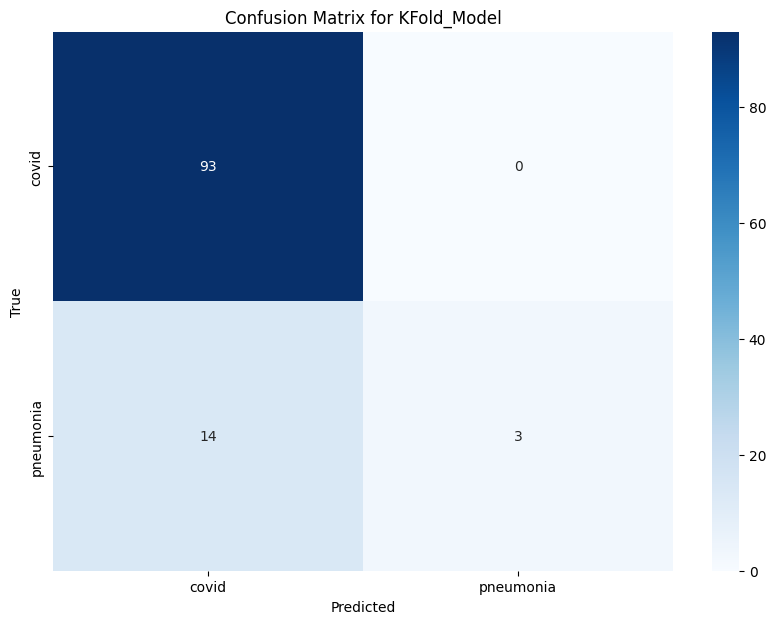


Average Validation Accuracy across 5 folds: 0.9273
Average Validation Loss across 5 folds: 8.6515
Average Training Time per fold: 57.63 seconds


In [11]:
# Train ResNet50 Model

# Now loop over folds instead of manually splitting
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model_resnet.trainable = False

history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes = build_and_train_model_kfold(
    base_model=base_model_resnet,
    X=X_train,
    Y=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    labels=labels,
    model_name='KFold_Model',
    k_folds=5
)

# history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50')



In [13]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

NameError: name 'conf_matrix_resnet' is not defined

In [ ]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

In [ ]:
import numpy as np
import hashlib

def get_image_hash(image_array):
    """Compute hash of an image numpy array to detect duplicates."""
    hasher = hashlib.md5()
    hasher.update(image_array.tobytes())  # Convert image array to bytes
    return hasher.hexdigest()

def check_duplicate_images(X_train, X_val, X_test):
    """Checks for duplicate images across train, validation, and test sets."""
    sets = {'train': X_train, 'val': X_val, 'test': X_test}
    hash_dict = {}

    for split, images in sets.items():
        for i, img in enumerate(images):
            img_hash = get_image_hash(img)
            if img_hash in hash_dict:
                print(f"⚠️ Duplicate image found between {split} and {hash_dict[img_hash]}!")
            hash_dict[img_hash] = split  # Store where the hash was first seen

    print("✅ No duplicate images found between train, val, and test sets!")

# Run check
check_duplicate_images(X_train, X_val, X_test)
